Setup

In [9]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score

from models_unsupervised import train_isoforest, train_autoencoder, score_autoencoder
from evaluate import evaluate_unsupervised

# --- Paths ---
PROC_DIR = Path("../data/processed")
TABLE_DIR = Path("../reports/tables")
TABLE_DIR.mkdir(exist_ok=True, parents=True)

Load processed dataset

In [2]:
df = pd.read_csv(PROC_DIR / "creditcard_processed.csv.gz")
X = df.drop(columns=["Class"])
y = df["Class"]

Train/validation split

In [3]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Isolation Forest

In [4]:
iso_cfg = {"n_estimators": 300, "contamination": 0.002}
iso_model, iso_metrics, iso_scores = train_isoforest(X_tr, X_val, y_val, iso_cfg)

print("Isolation Forest metrics:", iso_metrics)


prec, rec, thr = precision_recall_curve(y_val, iso_scores)
f1s = [f1_score(y_val, iso_scores >= t) for t in thr]
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
print(f"Best IF threshold={best_thr:.4f}, F1={f1s[best_idx]:.3f}")

Isolation Forest metrics: {'roc_auc': 0.938764494332334, 'pr_auc': 0.0957786040099566}
Best IF threshold=0.6175, F1=0.219


Autoencoder

In [5]:
X_tr_legit = X_tr[y_tr == 0]
X_val_legit = X_val[y_val == 0]

ae_cfg = {"epochs": 20, "batch_size": 512, "latent_dim": 16}
ae_model, ae_hist = train_autoencoder(X_tr_legit, X_val_legit, ae_cfg)

# Compute reconstruction error on val set
ae_scores = score_autoencoder(ae_model, X_val)

Epoch 1/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4806 - val_loss: 0.2694
Epoch 2/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1980 - val_loss: 0.1883
Epoch 3/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1322 - val_loss: 0.1157
Epoch 4/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1035 - val_loss: 0.0959
Epoch 5/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0911 - val_loss: 0.0861
Epoch 6/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0820 - val_loss: 0.0783
Epoch 7/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0764 - val_loss: 0.0766
Epoch 8/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0713 - val_loss: 0.0777
Epoch 9/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0675 - val_loss: 0.0668
Epoch 10/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0635 - val_loss: 0.0614
Epoch 11/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0589 - val_loss: 0.0603
Epoch 12/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Evaluate with PR curve

In [6]:
prec, rec, thr = precision_recall_curve(y_val, ae_scores)
f1s = [f1_score(y_val, ae_scores >= t) for t in thr]
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
print(f"Best AE threshold={best_thr:.6f}, F1={f1s[best_idx]:.3f}")

Best AE threshold=1.566558, F1=0.480


Evaluation metrics

In [10]:
# --- Isolation Forest full metrics ---
iso_eval = evaluate_unsupervised(y_val, iso_scores, threshold=best_thr)
print("Isolation Forest metrics:", iso_eval)

# --- Autoencoder full metrics ---
ae_eval = evaluate_unsupervised(y_val, ae_scores, threshold=best_thr)
print("Autoencoder metrics:", ae_eval)

# --- Save results ---
import pandas as pd
results = pd.DataFrame([
    {"model": "Isolation Forest", **{k:v for k,v in iso_eval.items() if k != "confusion_matrix"}},
    {"model": "Autoencoder", **{k:v for k,v in ae_eval.items() if k != "confusion_matrix"}},
])
results.to_csv(TABLE_DIR / "unsupervised_results.csv", index=False)
results


Isolation Forest metrics: {'roc_auc': 0.938764494332334, 'pr_auc': 0.0957786040099566, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'confusion_matrix': [[56651, 0], [95, 0]]}
Autoencoder metrics: {'roc_auc': 0.9194164826374599, 'pr_auc': 0.36945222881834366, 'precision': 0.5119047619047619, 'recall': 0.45263157894736844, 'f1': 0.48044692737430167, 'confusion_matrix': [[56610, 41], [52, 43]]}


,model,roc_auc,pr_auc,precision,recall,f1
0,Isolation Forest,0.938764,0.095779,0.000000,0.000000,0.000000
1,Autoencoder,0.919416,0.369452,0.511905,0.452632,0.480447


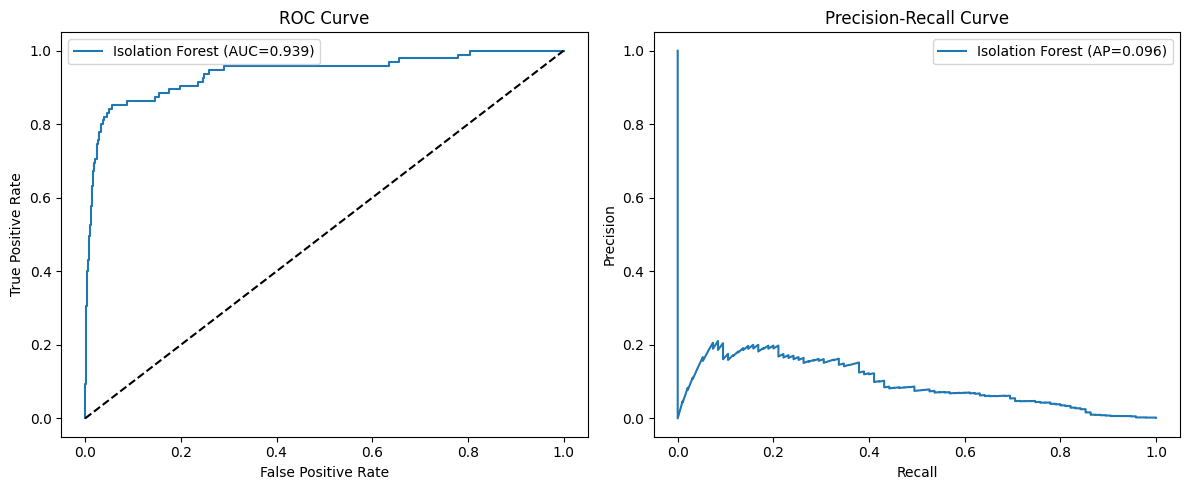

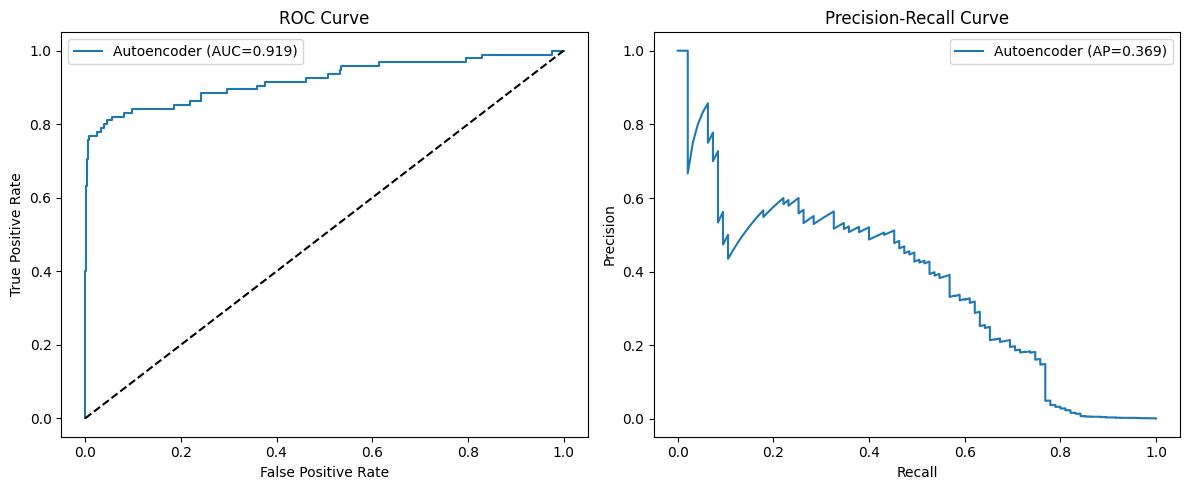

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

def plot_curves(y_true, scores, label):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)

    plt.subplot(1,2,2)
    plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_curves(y_val, iso_scores, "Isolation Forest")
plot_curves(y_val, ae_scores, "Autoencoder")


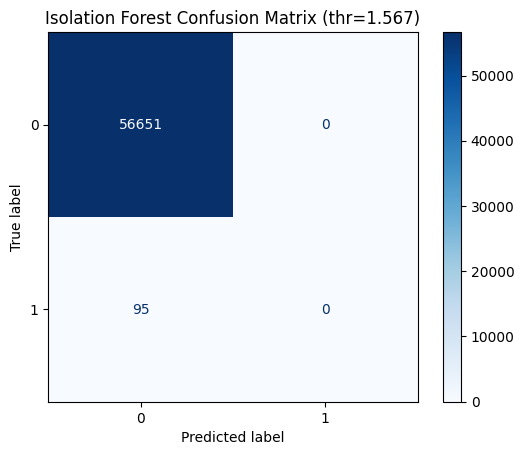

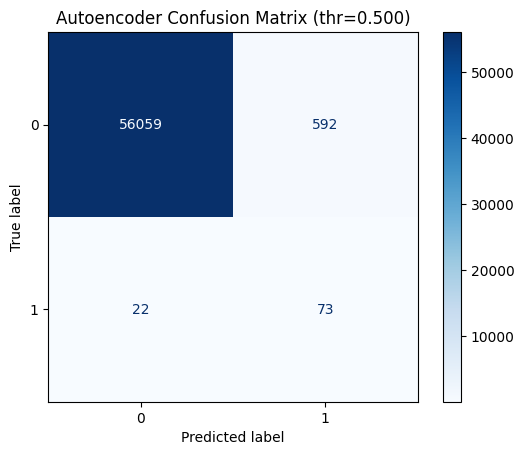

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
def plot_unsupervised_confusion(y_true, scores, threshold, label="Model"):
    y_pred = (scores >= threshold).astype(int)
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
    disp.ax_.set_title(f"{label} Confusion Matrix (thr={threshold:.3f})")
    plt.show()

# --- Confusion Matrix for Isolation Forest ---
plot_unsupervised_confusion(y_val, iso_scores, best_thr, label="Isolation Forest")

# --- Confusion Matrix for Autoencoder ---
plot_unsupervised_confusion(y_val, ae_scores, 0.5, label="Autoencoder")
